## Fine-tuned MobileNetV2

In [5]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, GlobalAveragePooling2D,
                                     BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S, preprocess_input
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, ReduceLROnPlateau)
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
# import flatten
from tensorflow.keras.layers import Flatten

# ===========================================================
# 1. Parameters
# ===========================================================
IMG_SIZE    = (300, 300)
BATCH_SIZE  = 32
VAL_SPLIT   = 0.2
NUM_CLASSES = 5
EXTRACT_PATH = "dataset(5dishes)"  # <-- Update this to your dataset path

# ===========================================================
# 2. Augmentation
# ===========================================================
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VAL_SPLIT,
    rotation_range=30,
    shear_range=0.25,
    zoom_range=(0.75, 1.25),
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range=20.0,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
)

train_gen = datagen.flow_from_directory(
    os.path.join(EXTRACT_PATH, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True,
)

val_gen = datagen.flow_from_directory(
    os.path.join(EXTRACT_PATH, "validate"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
)

# 1.2: Transfer learning
base_model = tf.keras.applications.MobileNetV2(input_shape=(300, 300, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze base model layers
base_model.trainable = False

# Show the base model architecture
base_model.summary()


# show the number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# 1.2: Build the architecture of MobileNetV2
# extract the last layer of the base model
last_layer = base_model.get_layer('out_relu')
last_output = last_layer.output

# add classification layers on top of the base model
x = Flatten()(last_output)
# add batch normalization
x = BatchNormalization()(x)
# add a fully connected layer with 1024 hidden units
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)

# define a model using the base model and the new classification layers
model = Model(base_model.input, outputs=pred)

# Show the model architecture
model.summary()

Found 2864 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


/var/folders/d5/z9jzrbjx4bncdccptn36y0h40000gn/T/ipykernel_21760/1888588874.py:62: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(300, 300, 3),


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 150, 150,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 150, 150,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 150, 150,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 150, 150,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 150, 150,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 150, 150,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 150, 150,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 150, 150,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 151, 151,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 75, 75,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 75, 75,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 75, 75,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 75, 75,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Number of layers in the base model:  154


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 150, 150,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 150, 150,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 150, 150,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 150, 150,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 150, 150,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 150, 150,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 150, 150,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 150, 150,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 151, 151,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 75, 75,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 75, 75,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 75, 75,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 75, 75,    │      2,304 │ block_1_depthwis

 Total params: 133,848,133 (510.59 MB)

 Trainable params: 131,334,149 (501.00 MB)

 Non-trainable params: 2,513,984 (9.59 MB)

In [7]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 10
batch_size = 1024

# train the model
history = model.fit(train_gen,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_gen)

Epoch 1/10


2025-05-15 02:41:33.680464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 750ms/step - accuracy: 0.3773 - loss: 5.4758 - val_accuracy: 0.3800 - val_loss: 7.2267
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 602ms/step - accuracy: 0.5214 - loss: 5.7980 - val_accuracy: 0.5400 - val_loss: 6.3983
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 693ms/step - accuracy: 0.5416 - loss: 5.7979 - val_accuracy: 0.5600 - val_loss: 5.1881
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 85s 944ms/step - accuracy: 0.5609 - loss: 6.3457 - val_accuracy: 0.5900 - val_loss: 6.1416
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 83s 916ms/step - accuracy: 0.5724 - loss: 6.1115 - val_accuracy: 0.5600 - val_loss: 7.5806
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 77s 845ms/step - accuracy: 0.5855 - loss: 6.0513 - val_accuracy: 0.6500 - val_loss: 6.1780
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6080 - loss: 5.9847 - val_accuracy: 0.5500 - val_loss: 7.9800
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.5762 - loss: 6.2610 - val_accuracy: 0.6100 - va

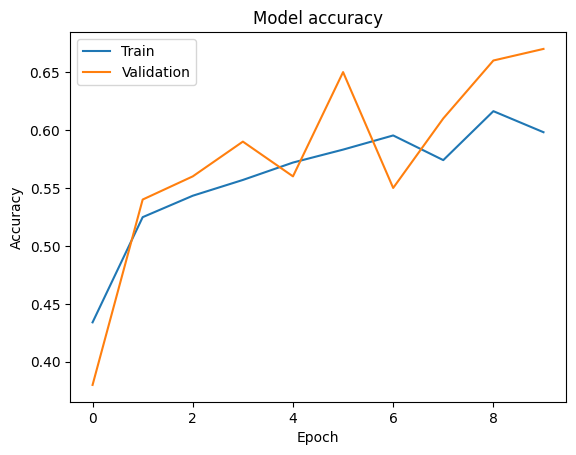

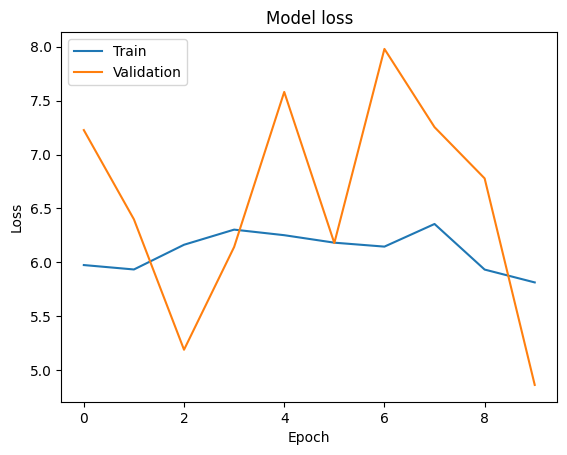

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.6365 - loss: 6.1692
Validation Loss: 6.1330
Validation Accuracy: 0.6200


In [8]:
# test and save the model
model.save('model.h5')
# ===========================================================
# 3. Evaluation
# ===========================================================
# 3.1: Plot the training and validation accuracy and loss
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
plot_history(history)
# 3.2: Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

## Fusion Approach

In [12]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

# Parameters
IMG_SIZE = (300, 300)
DATASET_PATH = "dataset(5dishes)/train"  # Your training dataset folder
CLASS_NAMES = ["Pho", "Goi cuon", "Banh mi", "Banh xeo", "Com tam"]

# Load pretrained MobileNetV2 base for embeddings
base_model = tf.keras.applications.MobileNetV2(input_shape=(300, 300, 3),
                                               include_top=False,
                                               weights='imagenet')

embedding_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])
embedding_model.trainable = False

def get_embedding(image_path):
    img = keras_image.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    embedding = embedding_model.predict(img_array, verbose=0)
    return embedding.flatten()

def get_color_histogram(image_path, bins_per_channel=8):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [bins_per_channel], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.extend(hist)
    return np.array(hist_features)

def get_sift_feature_count(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, _ = sift.detectAndCompute(gray, None)
    return len(keypoints)

def get_fused_feature_vector(image_path):
    embedding = get_embedding(image_path)
    color_hist = get_color_histogram(image_path)
    sift_count = get_sift_feature_count(image_path)
    fused_vector = np.concatenate([embedding, color_hist, [sift_count]])
    return fused_vector

# Extract features and labels from dataset
features = []
labels = []

for class_idx, class_name in enumerate(CLASS_NAMES):
    class_folder = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(class_folder):
        continue
    for filename in os.listdir(class_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(class_folder, filename)
            print(f"Processing {filename}")
            fused_vector = get_fused_feature_vector(image_path)
            features.append(fused_vector)
            labels.append(class_idx)

features = np.array(features)
labels = np.array(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

# Save the trained classifier
joblib.dump(clf, "fused_dish_classifier.pkl")
print("✅ Saved trained fusion classifier as 'fused_dish_classifier.pkl'")

/var/folders/d5/z9jzrbjx4bncdccptn36y0h40000gn/T/ipykernel_21760/498446443.py:18: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(300, 300, 3),


Processing 638.jpg
Processing 604.jpg
Processing 162.jpg
Processing 176.jpg
Processing 88.jpg
Processing 610.jpg
Processing 406.jpg
Processing 374.jpg
Processing 214.jpg
Processing 566.jpg
Processing 200.jpg
Processing 758.jpg
Processing 770.jpg
Processing 764.jpg
Processing 771.jpg
Processing 759.jpg
Processing 567.jpg
Processing 215.jpg
Processing 573.jpg
Processing 229.jpg
Processing 598.jpg
Processing 413.jpg
Processing 361.jpg
Processing 407.jpg
Processing 611.jpg
Processing 89.jpg
Processing 605.jpg
Processing 163.jpg
Processing 188.jpg
Processing 74.jpg
Processing 60.jpg
Processing 48.jpg
Processing 149.jpg
Processing 613.jpg
Processing 175.jpg
Processing 607.jpg
Processing 388.jpg
Processing 377.jpg
Processing 411.jpg
Processing 559.jpg
Processing 203.jpg
Processing 217.jpg
Processing 798.jpg
Processing 767.jpg
Processing 773.jpg
Processing 766.jpg
Processing 570.jpg
Processing 202.jpg
Processing 564.jpg
Processing 558.jpg
Processing 376.jpg
Processing 410.jpg
Processing 438.jp

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Processing 431.jpg
Processing 419.jpg
Processing 394.jpg
Processing 141.jpg
Processing 633.jpg
Processing 155.jpg
Processing 83.jpg
Processing 169.jpg


Corrupt JPEG data: 229 extraneous bytes before marker 0xd9
Corrupt JPEG data: 229 extraneous bytes before marker 0xd9


Processing 182.jpg
Processing 828.jpg
Processing 68.jpg
Processing 196.jpg
Processing 800.jpg
Processing 40.jpg
Processing 54.jpg
Processing 6.jpg
Processing 192.jpg
Processing 50.jpg
Processing 810.jpg
Processing 44.jpg
Processing 804.jpg
Processing 151.jpg
Processing 637.jpg
Processing 623.jpg
Processing 93.jpg
Processing 179.jpg
Processing 390.jpg
Processing 384.jpg
Processing 435.jpg
Processing 347.jpg
Processing 421.jpg
Processing 409.jpg
Processing 596.jpg
Processing 541.jpg
Processing 227.jpg
Processing 233.jpg
Processing 780.jpg
Processing 743.jpg
Processing 757.jpg
Processing 795.jpg
Processing 781.jpg
Processing 568.jpg
Processing 232.jpg
Processing 554.jpg
Processing 540.jpg
Processing 226.jpg
Processing 597.jpg
Processing 346.jpg
Processing 420.jpg
Processing 352.jpg
Processing 391.jpg
Processing 86.jpg
Processing 178.jpg
Processing 92.jpg
Processing 622.jpg
Processing 144.jpg
Processing 150.jpg
Processing 636.jpg
Processing 45.jpg
Processing 3.jpg
Processing 811.jpg
Proces

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


Processing 48.jpg
Processing 149.jpg
Processing 175.jpg
Processing 161.jpg
Processing 388.jpg
Processing 1146.jpg
Processing 1152.jpg
Processing 439.jpg
Processing 411.jpg
Processing 405.jpg
Processing 1032.jpg
Processing 203.jpg
Processing 571.jpg
Processing 217.jpg
Processing 940.jpg
Processing 798.jpg
Processing 954.jpg
Processing 968.jpg
Processing 983.jpg
Processing 997.jpg
Processing 773.jpg
Processing 772.jpg
Processing 766.jpg
Processing 996.jpg
Processing 982.jpg
Processing 969.jpg
Processing 799.jpg
Processing 941.jpg
Processing 570.jpg
Processing 216.jpg
Processing 202.jpg
Processing 558.jpg
Processing 1027.jpg
Processing 1033.jpg
Processing 404.jpg
Processing 362.jpg
Processing 376.jpg
Processing 410.jpg
Processing 438.jpg
Processing 1153.jpg
Processing 1147.jpg
Processing 612.jpg
Processing 148.jpg
Processing 49.jpg
Processing 821.jpg
Processing 61.jpg
Processing 835.jpg
Processing 75.jpg
Processing 59.jpg
Processing 819.jpg
Processing 71.jpg
Processing 831.jpg
Processing 

In [18]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
import joblib

# ===========================================================
# 1. Parameters
# ===========================================================
IMG_SIZE = (300, 300)
CLASS_NAMES = ["Pho", "Goi cuon", "Banh mi", "Banh xeo", "Com tam"]

# ===========================================================
# 2. Load Trained Models
# ===========================================================
cnn_model = tf.keras.models.load_model("model.h5")
embedding_model = tf.keras.models.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer("out_relu").output
)
fusion_clf = joblib.load("fused_dish_classifier.pkl")

print("✅ Models loaded.")

# ===========================================================
# 3. Feature Extractors
# ===========================================================
def get_embedding(image_path):
    img = keras_image.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    feature_map = embedding_model.predict(img_array, verbose=0)
    pooled = tf.keras.layers.GlobalAveragePooling2D()(tf.convert_to_tensor(feature_map))
    return pooled.numpy().flatten()

def get_color_histogram(image_path, bins_per_channel=8):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [bins_per_channel], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.extend(hist)
    return np.array(hist_features)

def get_sift_feature_count(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, _ = sift.detectAndCompute(gray, None)
    return len(keypoints)

def get_fused_feature_vector(image_path):
    embedding = get_embedding(image_path)
    color_hist = get_color_histogram(image_path)
    sift_count = get_sift_feature_count(image_path)
    fused_vector = np.concatenate([embedding, color_hist, [sift_count]])
    return fused_vector

# ===========================================================
# 4. Predict a Folder of Images
# ===========================================================
def predict_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            print(f"File: {filename}\n  CNN Prediction: {cnn_prediction}\n  Fused Prediction: {fusion_prediction}\n")

# ===========================================================
# 5. Run prediction
# ===========================================================
#calculate the accuracy of test set of CNN prediction and Fused prediction
def calculate_accuracy(folder_path):
    correct_cnn = 0
    correct_fusion = 0
    total = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            total += 1

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            # Check if the prediction is correct
            if "Banh xeo" in filename and cnn_prediction == "Banh xeo":
                correct_cnn += 1
            if "Banh xeo" in filename and fusion_prediction == "Banh xeo":
                correct_fusion += 1

    print(f"Total images: {total}")
    print(f"CNN Correct Predictions: {correct_cnn} / {total} ({(correct_cnn / total) * 100:.2f}%)")
    print(f"Fused Correct Predictions: {correct_fusion} / {total} ({(correct_fusion / total) * 100:.2f}%)")

def test_accuracy_on_folder(folder_path, true_class_name):
    total = 0
    correct_cnn = 0
    correct_fusion = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            # Count correct predictions
            total += 1
            if cnn_prediction == true_class_name:
                correct_cnn += 1
            if fusion_prediction == true_class_name:
                correct_fusion += 1

            print(f"File: {filename}\n  CNN Prediction: {cnn_prediction}\n  Fused Prediction: {fusion_prediction}\n")

    # Calculate and print accuracy
    cnn_acc = correct_cnn / total * 100
    fusion_acc = correct_fusion / total * 100
    print(f"📊 CNN accuracy on '{true_class_name}': {cnn_acc:.2f}% ({correct_cnn}/{total})")
    print(f"📊 Fusion accuracy on '{true_class_name}': {fusion_acc:.2f}% ({correct_fusion}/{total})")

#calculate_accuracy("dataset(5dishes)/Test/Banh xeo")
test_accuracy_on_folder("dataset(5dishes)/Test/Banh xeo", "Banh xeo")

✅ Models loaded.
File: 823.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Goi cuon

File: 189.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Banh xeo

File: 162.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Banh xeo

File: 88.jpg
  CNN Prediction: Com tam
  Fused Prediction: Banh xeo

File: 348.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Banh xeo

File: 566.jpg
  CNN Prediction: Goi cuon
  Fused Prediction: Banh xeo

File: 980.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Banh xeo

File: 573.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Banh xeo

File: 1024.jpg
  CNN Prediction: Goi cuon
  Fused Prediction: Banh xeo

File: 413.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Banh xeo

File: 375.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Banh xeo

File: 177.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Banh xeo

File: 188.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Banh xeo

File: 74.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Banh xe

In [20]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
import joblib

# ===========================================================
# 1. Parameters
# ===========================================================
IMG_SIZE = (300, 300)
CLASS_NAMES = ["Pho", "Goi cuon", "Banh mi", "Banh xeo", "Com tam"]

# ===========================================================
# 2. Load Trained Models
# ===========================================================
cnn_model = tf.keras.models.load_model("model.h5")
embedding_model = tf.keras.models.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer("out_relu").output
)
fusion_clf = joblib.load("fused_dish_classifier.pkl")

print("✅ Models loaded.")

# ===========================================================
# 3. Feature Extractors
# ===========================================================
def get_embedding(image_path):
    img = keras_image.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    feature_map = embedding_model.predict(img_array, verbose=0)
    pooled = tf.keras.layers.GlobalAveragePooling2D()(tf.convert_to_tensor(feature_map))
    return pooled.numpy().flatten()

def get_color_histogram(image_path, bins_per_channel=8):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [bins_per_channel], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.extend(hist)
    return np.array(hist_features)

def get_sift_feature_count(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, _ = sift.detectAndCompute(gray, None)
    return len(keypoints)

def get_fused_feature_vector(image_path):
    embedding = get_embedding(image_path)
    color_hist = get_color_histogram(image_path)
    sift_count = get_sift_feature_count(image_path)
    fused_vector = np.concatenate([embedding, color_hist, [sift_count]])
    return fused_vector

# ===========================================================
# 4. Predict a Folder of Images
# ===========================================================
def predict_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            print(f"File: {filename}\n  CNN Prediction: {cnn_prediction}\n  Fused Prediction: {fusion_prediction}\n")

# ===========================================================
# 5. Run prediction
# ===========================================================
#calculate the accuracy of test set of CNN prediction and Fused prediction
def calculate_accuracy(folder_path):
    correct_cnn = 0
    correct_fusion = 0
    total = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            total += 1

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            # Check if the prediction is correct
            if "Banh xeo" in filename and cnn_prediction == "Banh xeo":
                correct_cnn += 1
            if "Banh xeo" in filename and fusion_prediction == "Banh xeo":
                correct_fusion += 1

    print(f"Total images: {total}")
    print(f"CNN Correct Predictions: {correct_cnn} / {total} ({(correct_cnn / total) * 100:.2f}%)")
    print(f"Fused Correct Predictions: {correct_fusion} / {total} ({(correct_fusion / total) * 100:.2f}%)")

def test_accuracy_on_folder(folder_path, true_class_name):
    total = 0
    correct_cnn = 0
    correct_fusion = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            # Count correct predictions
            total += 1
            if cnn_prediction == true_class_name:
                correct_cnn += 1
            if fusion_prediction == true_class_name:
                correct_fusion += 1

            print(f"File: {filename}\n  CNN Prediction: {cnn_prediction}\n  Fused Prediction: {fusion_prediction}\n")

    # Calculate and print accuracy
    cnn_acc = correct_cnn / total * 100
    fusion_acc = correct_fusion / total * 100
    print(f"📊 CNN accuracy on '{true_class_name}': {cnn_acc:.2f}% ({correct_cnn}/{total})")
    print(f"📊 Fusion accuracy on '{true_class_name}': {fusion_acc:.2f}% ({correct_fusion}/{total})")

#calculate_accuracy("dataset(5dishes)/Test/Banh xeo")
test_accuracy_on_folder("dataset(5dishes)/Test/Com tam", "Com tam")

✅ Models loaded.
File: 77.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Com tam

File: 162.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Com tam

File: 228.jpg
  CNN Prediction: Com tam
  Fused Prediction: Com tam

File: 572.jpg
  CNN Prediction: Com tam
  Fused Prediction: Com tam

File: 566.jpg
  CNN Prediction: Com tam
  Fused Prediction: Com tam

File: 764.jpg
  CNN Prediction: Com tam
  Fused Prediction: Com tam

File: 942.jpg
  CNN Prediction: Com tam
  Fused Prediction: Com tam

File: 375.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Com tam

File: 349.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Com tam

File: 89.jpg
  CNN Prediction: Com tam
  Fused Prediction: Com tam

File: 822.jpg
  CNN Prediction: Com tam
  Fused Prediction: Com tam

File: 60.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Com tam

File: 613.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Com tam

File: 559.jpg
  CNN Prediction: Com tam
  Fused Prediction: Com tam

File: 798.jpg
  

In [21]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
import joblib

# ===========================================================
# 1. Parameters
# ===========================================================
IMG_SIZE = (300, 300)
CLASS_NAMES = ["Pho", "Goi cuon", "Banh mi", "Banh xeo", "Com tam"]

# ===========================================================
# 2. Load Trained Models
# ===========================================================
cnn_model = tf.keras.models.load_model("model.h5")
embedding_model = tf.keras.models.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer("out_relu").output
)
fusion_clf = joblib.load("fused_dish_classifier.pkl")

print("✅ Models loaded.")

# ===========================================================
# 3. Feature Extractors
# ===========================================================
def get_embedding(image_path):
    img = keras_image.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    feature_map = embedding_model.predict(img_array, verbose=0)
    pooled = tf.keras.layers.GlobalAveragePooling2D()(tf.convert_to_tensor(feature_map))
    return pooled.numpy().flatten()

def get_color_histogram(image_path, bins_per_channel=8):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [bins_per_channel], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.extend(hist)
    return np.array(hist_features)

def get_sift_feature_count(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, _ = sift.detectAndCompute(gray, None)
    return len(keypoints)

def get_fused_feature_vector(image_path):
    embedding = get_embedding(image_path)
    color_hist = get_color_histogram(image_path)
    sift_count = get_sift_feature_count(image_path)
    fused_vector = np.concatenate([embedding, color_hist, [sift_count]])
    return fused_vector

# ===========================================================
# 4. Predict a Folder of Images
# ===========================================================
def predict_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            print(f"File: {filename}\n  CNN Prediction: {cnn_prediction}\n  Fused Prediction: {fusion_prediction}\n")

# ===========================================================
# 5. Run prediction
# ===========================================================
#calculate the accuracy of test set of CNN prediction and Fused prediction
def calculate_accuracy(folder_path):
    correct_cnn = 0
    correct_fusion = 0
    total = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            total += 1

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            # Check if the prediction is correct
            if "Banh xeo" in filename and cnn_prediction == "Banh xeo":
                correct_cnn += 1
            if "Banh xeo" in filename and fusion_prediction == "Banh xeo":
                correct_fusion += 1

    print(f"Total images: {total}")
    print(f"CNN Correct Predictions: {correct_cnn} / {total} ({(correct_cnn / total) * 100:.2f}%)")
    print(f"Fused Correct Predictions: {correct_fusion} / {total} ({(correct_fusion / total) * 100:.2f}%)")

def test_accuracy_on_folder(folder_path, true_class_name):
    total = 0
    correct_cnn = 0
    correct_fusion = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            # Count correct predictions
            total += 1
            if cnn_prediction == true_class_name:
                correct_cnn += 1
            if fusion_prediction == true_class_name:
                correct_fusion += 1

            print(f"File: {filename}\n  CNN Prediction: {cnn_prediction}\n  Fused Prediction: {fusion_prediction}\n")

    # Calculate and print accuracy
    cnn_acc = correct_cnn / total * 100
    fusion_acc = correct_fusion / total * 100
    print(f"📊 CNN accuracy on '{true_class_name}': {cnn_acc:.2f}% ({correct_cnn}/{total})")
    print(f"📊 Fusion accuracy on '{true_class_name}': {fusion_acc:.2f}% ({correct_fusion}/{total})")

#calculate_accuracy("dataset(5dishes)/Test/Banh xeo")
test_accuracy_on_folder("dataset(5dishes)/Test/Goi cuon", "Goi cuon")

✅ Models loaded.
File: 823.jpg
  CNN Prediction: Com tam
  Fused Prediction: Banh mi

File: 610.jpg
  CNN Prediction: Pho
  Fused Prediction: Goi cuon

File: 348.jpg
  CNN Prediction: Com tam
  Fused Prediction: Goi cuon

File: 360.jpg
  CNN Prediction: Pho
  Fused Prediction: Goi cuon

File: 758.jpg
  CNN Prediction: Com tam
  Fused Prediction: Goi cuon

File: 770.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Banh mi

File: 764.jpg
  CNN Prediction: Goi cuon
  Fused Prediction: Goi cuon

File: 765.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Banh mi

File: 413.jpg
  CNN Prediction: Com tam
  Fused Prediction: Goi cuon

File: 361.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Goi cuon

File: 89.jpg
  CNN Prediction: Com tam
  Fused Prediction: Goi cuon

File: 822.jpg
  CNN Prediction: Com tam
  Fused Prediction: Goi cuon

File: 149.jpg
  CNN Prediction: Com tam
  Fused Prediction: Goi cuon

File: 405.jpg
  CNN Prediction: Pho
  Fused Prediction: Goi cuon

File: 203.jpg
  

In [22]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
import joblib

# ===========================================================
# 1. Parameters
# ===========================================================
IMG_SIZE = (300, 300)
CLASS_NAMES = ["Pho", "Goi cuon", "Banh mi", "Banh xeo", "Com tam"]

# ===========================================================
# 2. Load Trained Models
# ===========================================================
cnn_model = tf.keras.models.load_model("model.h5")
embedding_model = tf.keras.models.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer("out_relu").output
)
fusion_clf = joblib.load("fused_dish_classifier.pkl")

print("✅ Models loaded.")

# ===========================================================
# 3. Feature Extractors
# ===========================================================
def get_embedding(image_path):
    img = keras_image.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    feature_map = embedding_model.predict(img_array, verbose=0)
    pooled = tf.keras.layers.GlobalAveragePooling2D()(tf.convert_to_tensor(feature_map))
    return pooled.numpy().flatten()

def get_color_histogram(image_path, bins_per_channel=8):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [bins_per_channel], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.extend(hist)
    return np.array(hist_features)

def get_sift_feature_count(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, _ = sift.detectAndCompute(gray, None)
    return len(keypoints)

def get_fused_feature_vector(image_path):
    embedding = get_embedding(image_path)
    color_hist = get_color_histogram(image_path)
    sift_count = get_sift_feature_count(image_path)
    fused_vector = np.concatenate([embedding, color_hist, [sift_count]])
    return fused_vector

# ===========================================================
# 4. Predict a Folder of Images
# ===========================================================
def predict_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            print(f"File: {filename}\n  CNN Prediction: {cnn_prediction}\n  Fused Prediction: {fusion_prediction}\n")

# ===========================================================
# 5. Run prediction
# ===========================================================
#calculate the accuracy of test set of CNN prediction and Fused prediction
def calculate_accuracy(folder_path):
    correct_cnn = 0
    correct_fusion = 0
    total = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            total += 1

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            # Check if the prediction is correct
            if "Banh xeo" in filename and cnn_prediction == "Banh xeo":
                correct_cnn += 1
            if "Banh xeo" in filename and fusion_prediction == "Banh xeo":
                correct_fusion += 1

    print(f"Total images: {total}")
    print(f"CNN Correct Predictions: {correct_cnn} / {total} ({(correct_cnn / total) * 100:.2f}%)")
    print(f"Fused Correct Predictions: {correct_fusion} / {total} ({(correct_fusion / total) * 100:.2f}%)")

def test_accuracy_on_folder(folder_path, true_class_name):
    total = 0
    correct_cnn = 0
    correct_fusion = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            # Count correct predictions
            total += 1
            if cnn_prediction == true_class_name:
                correct_cnn += 1
            if fusion_prediction == true_class_name:
                correct_fusion += 1

            print(f"File: {filename}\n  CNN Prediction: {cnn_prediction}\n  Fused Prediction: {fusion_prediction}\n")

    # Calculate and print accuracy
    cnn_acc = correct_cnn / total * 100
    fusion_acc = correct_fusion / total * 100
    print(f"📊 CNN accuracy on '{true_class_name}': {cnn_acc:.2f}% ({correct_cnn}/{total})")
    print(f"📊 Fusion accuracy on '{true_class_name}': {fusion_acc:.2f}% ({correct_fusion}/{total})")

#calculate_accuracy("dataset(5dishes)/Test/Banh xeo")
test_accuracy_on_folder("dataset(5dishes)/Test/Banh mi", "Banh mi")

✅ Models loaded.
File: 162.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Banh mi

File: 348.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Banh mi

File: 360.jpg
  CNN Prediction: Com tam
  Fused Prediction: Banh mi

File: 1025.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Banh mi

File: 214.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Banh mi

File: 572.jpg
  CNN Prediction: Com tam
  Fused Prediction: Banh mi

File: 566.jpg
  CNN Prediction: Pho
  Fused Prediction: Banh mi

File: 1233.jpg
  CNN Prediction: Goi cuon
  Fused Prediction: Banh mi

File: 980.jpg
  CNN Prediction: Com tam
  Fused Prediction: Banh mi

File: 770.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Banh mi

File: 1030.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Banh mi

File: 1024.jpg
  CNN Prediction: Com tam
  Fused Prediction: Banh mi

File: 413.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Banh mi

File: 375.jpg
  CNN Prediction: Com tam
  Fused Prediction: Banh mi

File: 349.j

In [23]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
import joblib

# ===========================================================
# 1. Parameters
# ===========================================================
IMG_SIZE = (300, 300)
CLASS_NAMES = ["Pho", "Goi cuon", "Banh mi", "Banh xeo", "Com tam"]

# ===========================================================
# 2. Load Trained Models
# ===========================================================
cnn_model = tf.keras.models.load_model("model.h5")
embedding_model = tf.keras.models.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer("out_relu").output
)
fusion_clf = joblib.load("fused_dish_classifier.pkl")

print("✅ Models loaded.")

# ===========================================================
# 3. Feature Extractors
# ===========================================================
def get_embedding(image_path):
    img = keras_image.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    feature_map = embedding_model.predict(img_array, verbose=0)
    pooled = tf.keras.layers.GlobalAveragePooling2D()(tf.convert_to_tensor(feature_map))
    return pooled.numpy().flatten()

def get_color_histogram(image_path, bins_per_channel=8):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [bins_per_channel], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.extend(hist)
    return np.array(hist_features)

def get_sift_feature_count(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, _ = sift.detectAndCompute(gray, None)
    return len(keypoints)

def get_fused_feature_vector(image_path):
    embedding = get_embedding(image_path)
    color_hist = get_color_histogram(image_path)
    sift_count = get_sift_feature_count(image_path)
    fused_vector = np.concatenate([embedding, color_hist, [sift_count]])
    return fused_vector

# ===========================================================
# 4. Predict a Folder of Images
# ===========================================================
def predict_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            print(f"File: {filename}\n  CNN Prediction: {cnn_prediction}\n  Fused Prediction: {fusion_prediction}\n")

# ===========================================================
# 5. Run prediction
# ===========================================================
#calculate the accuracy of test set of CNN prediction and Fused prediction
def calculate_accuracy(folder_path):
    correct_cnn = 0
    correct_fusion = 0
    total = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            total += 1

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            # Check if the prediction is correct
            if "Banh xeo" in filename and cnn_prediction == "Banh xeo":
                correct_cnn += 1
            if "Banh xeo" in filename and fusion_prediction == "Banh xeo":
                correct_fusion += 1

    print(f"Total images: {total}")
    print(f"CNN Correct Predictions: {correct_cnn} / {total} ({(correct_cnn / total) * 100:.2f}%)")
    print(f"Fused Correct Predictions: {correct_fusion} / {total} ({(correct_fusion / total) * 100:.2f}%)")

def test_accuracy_on_folder(folder_path, true_class_name):
    total = 0
    correct_cnn = 0
    correct_fusion = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)

            # CNN-only prediction
            img = keras_image.load_img(image_path, target_size=IMG_SIZE)
            img_array = keras_image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = cnn_model.predict(img_array, verbose=0)
            class_idx = np.argmax(predictions)
            cnn_prediction = CLASS_NAMES[class_idx]

            # Fusion prediction
            fused_vector = get_fused_feature_vector(image_path).reshape(1, -1)
            fusion_class_idx = fusion_clf.predict(fused_vector)[0]
            fusion_prediction = CLASS_NAMES[fusion_class_idx]

            # Count correct predictions
            total += 1
            if cnn_prediction == true_class_name:
                correct_cnn += 1
            if fusion_prediction == true_class_name:
                correct_fusion += 1

            print(f"File: {filename}\n  CNN Prediction: {cnn_prediction}\n  Fused Prediction: {fusion_prediction}\n")

    # Calculate and print accuracy
    cnn_acc = correct_cnn / total * 100
    fusion_acc = correct_fusion / total * 100
    print(f"📊 CNN accuracy on '{true_class_name}': {cnn_acc:.2f}% ({correct_cnn}/{total})")
    print(f"📊 Fusion accuracy on '{true_class_name}': {fusion_acc:.2f}% ({correct_fusion}/{total})")

#calculate_accuracy("dataset(5dishes)/Test/Banh xeo")
test_accuracy_on_folder("dataset(5dishes)/Test/Pho", "Pho")

✅ Models loaded.
File: 63.jpg
  CNN Prediction: Com tam
  Fused Prediction: Pho

File: 77.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Pho

File: 348.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Pho

File: 599.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Pho

File: 228.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Pho

File: 572.jpg
  CNN Prediction: Pho
  Fused Prediction: Pho

File: 201.jpg
  CNN Prediction: Com tam
  Fused Prediction: Pho

File: 349.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Pho

File: 177.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Pho

File: 639.jpg
  CNN Prediction: Banh mi
  Fused Prediction: Banh xeo

File: 76.jpg
  CNN Prediction: Com tam
  Fused Prediction: Pho

File: 62.jpg
  CNN Prediction: Com tam
  Fused Prediction: Pho

File: 161.jpg
  CNN Prediction: Com tam
  Fused Prediction: Pho

File: 439.jpg
  CNN Prediction: Pho
  Fused Prediction: Pho

File: 565.jpg
  CNN Prediction: Banh xeo
  Fused Prediction: Pho

File: 571.jp